<a href="https://colab.research.google.com/github/V1S10US/My-projects/blob/main/HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Меланин А.Г., А-16-20

# **Метод направленных градиентов** (Histogram of oriented gradients)
**Метод направленных градиентов** - метод получения дескрипторов для обработки изображений, которые отражают поле градиентов интенсивностей света участков изображения. Дескриптор изображения - более простое представление изображения или части изображения, выделяющее полезную для распознавания информацию и отбрасывающее неважную.

Принцип работы заключается в том, чтобы для каждого участка изображения посчитать гистограмму направлений и величину изменения яркости. Для обеспечения инвариантности по отношению к освещению гистограммы подвергаются нормализации по контрасту с мерой яркости, вычисленной по большему фрагменту. Совокупность построенных нормализованных гистограмм будет являться дескриптором объекта. Такие дескрипторы инвариантны к освещению, геометрическим и фотометрическим преобразованиям (за исключением ориентации самого объекта)




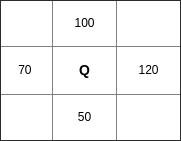

 - Изображение разбивается на 8 * 8 квадратов, в каждом из которых будет считаться градиент
Подсчет градиента

$ \frac{\partial G}{\partial x} = 120 - 70 = 50 $
$ \frac{\partial G}{\partial y} = 100 - 50 = 50 $
Такое преобразование можно  для всей матрицы использованием оператора Собеля, имнющего аналогичный вид:
$ G_y = \begin{bmatrix}
  1 & 2 & 1\\
  0 & 0 & 0 \\
  -1 & -2 & -1
\end{bmatrix} ,
G_x = \begin{bmatrix}
  -1 & 0 & 1\\
  -2 & 0 & 2 \\
  -1 & 0 & 1
\end{bmatrix} $

$ |dG| = \sqrt{\frac{\partial G}{\partial x}^2 + \frac{\partial G}{\partial y}^2} ≃ 70.7 $ - величина градиента
Направление : $ \beta = arctg(\frac{\partial G_y}{\partial G_x}) = 45 ° $
- гистограмма углов

Затем необходимо разделить исходное изображение на 8х8 квадратов для уменьшения влияния шума на вычисление градиентов.

После того, как будет получены матрицы углов и модулей векторов, задающих направление,  для каждого из 64 блоков, создается гистограмма направленных градиентов, состоящая из 9 частей, обозначающих величину изменения яркости по выделенному направлению.
Полуплоскость разбивается на части углами $\alpha_i = 0, 20, 40, ... 160$, определяющее направления для гистограммы направлений. Гистограмма заплоняется следующим образом:
 - если в точке угол $\alpha = \alpha_i$, то модуль для этой точке добавляется в массив для этого угла;
 - если в точке угол $\alpha \in [\alpha_i,  \alpha_j]$, то модуль пропорционально распределяется между двумя соседними углами $ \alpha_i,  \alpha_j $


В результате работы метода получается вектор направленных градиентов, который подается в модель классификации (в оригинальной работе SVM).


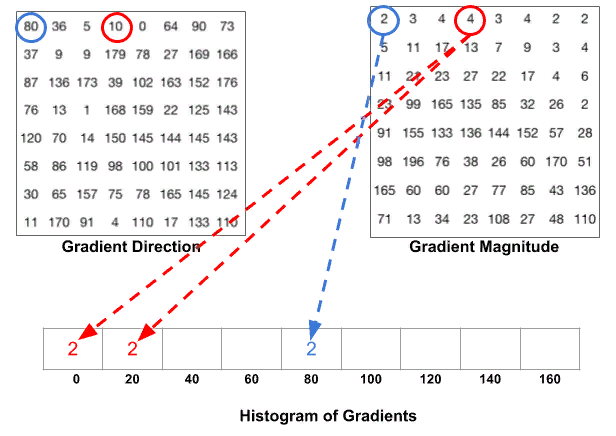

In [ ]:
from google.colab import drive  # подключение Google Drive для загрузки изображений
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
""" Imports """
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from skimage import transform, color
from sklearn.feature_extraction.image import PatchExtractor
from skimage import feature   # To use skimage.feature.hog()
from itertools import chain
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

<ipython-input-3-ef7b106284db>:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),


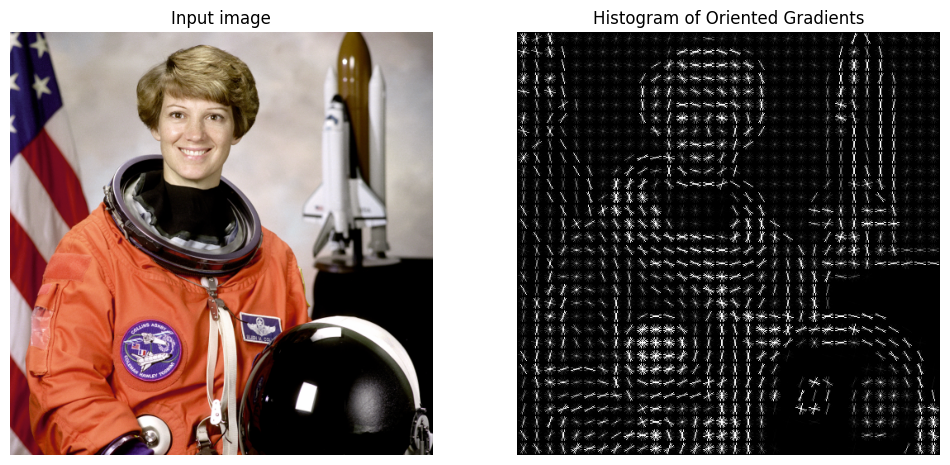

In [ ]:

%matplotlib inline


image = data.astronaut() # загрузить изображение из датасета из sklearn

# получение hog дескрипторов встроенным методом
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Масштабирование
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# вывод изображений
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Практическое применение метода для распознавания лиц на изображений

In [ ]:
# загрузка изображений лиц
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape ## 13233 лиц для обучения

(13233, 62, 47)

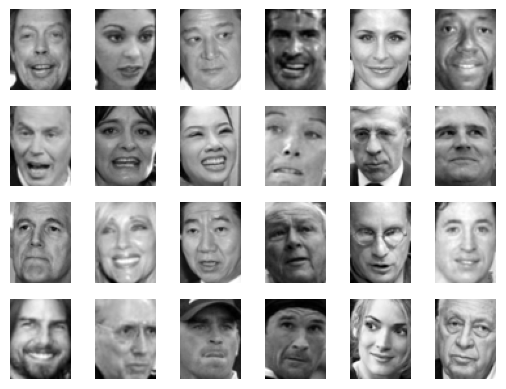

In [ ]:
# Изображения лица

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[500 * i], cmap='gray')
    axi.axis('off')

In [ ]:
# не лица

imgs_to_use = ['camera', 'text', 'coins', 'rocket',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)()) if getattr(data, name)().ndim == 3 else getattr(data, name)()
          for name in imgs_to_use]

In [ ]:
# Разбиение изображений выборки на патчи для уведличения количества примеров
#

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape  # 27000 images for negative set

(30000, 62, 47)

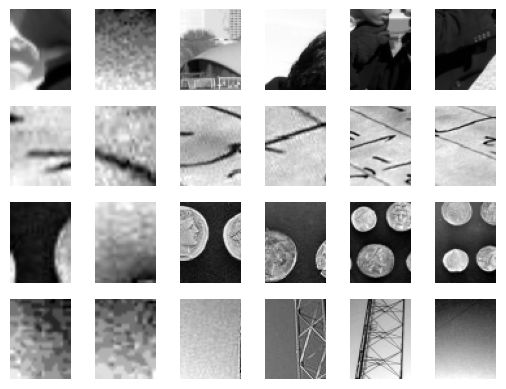

In [ ]:
# Отобразить примеры без лиц
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [ ]:

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

Классификация с помощью метода опорных векторов (Support Vector Machine with C-**S**upport **V**ector **C**lassification)

In [ ]:
# Обучение SVM классификатора.
# подбор лучших гиперпараметров для классификатора с помощью gridsearchCV

grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9892905882080818

In [ ]:
grid.best_params_

{'C': 1.0}

In [ ]:
# Обучение классификатора

model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(dual=False)

Для тестирования возьмем изображение из примера выше
Из него получим множество частей изображения. На некоторых будет присутствовать лицо, на некоторых - нет.

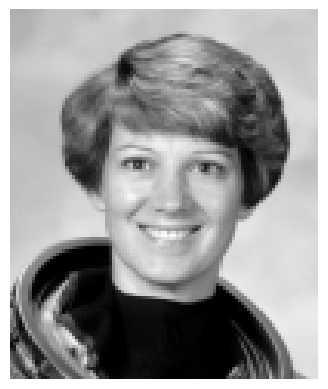

In [ ]:
test_img = data.astronaut()
test_img = color.rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off');

In [ ]:
# функция, которая возвращает патч изображения
# для последующего вычисления HOG на этом патче

def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [ ]:
# Получение множества HOG векторов патчей

indices, patches = zip(*sliding_window(test_img))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(551, 1215)

In [ ]:
# Предсказание меток

labels = model.predict(patches_hog)
labels.sum() # количество распознаний на всем множестве патчей

43.0

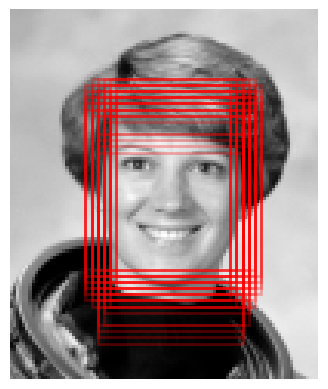

In [ ]:
# Отображение распознаных патчей
# (с каждым патчем хранится его индекс в начальном множестве)

fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

Подсчет направленных градиентов для изображения:


In [ ]:

class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        # Нормализация изображения
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255

        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 / self.bin_size


    def extract(self):
        height, width = self.img.shape
        # подсчет градиента для всего изображения
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((height // self.cell_size, width // self.cell_size, self.bin_size))
        # Распределение модулей между углами 0 - 160
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self): # посчитать градиент по всему изображению
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        # вычисление углов в каждой точке
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    # градиент для патча изображения
    def cell_gradient(self, cell_magnitude, cell_angle):
        # выделение массива под столбики диаграммы (bins)
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                # выбрать углы, для которых будет прибавлятся cell_magnitude
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    # выбор ближайших углов, между которыми будет распределяться модуль градиента
    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                # нормализация
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    # угол наклона прямой
                    angle_radian = math.radians(angle)
                    # вычисление координат концов прямых
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    # рисование прямых
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image



(-0.5, 419.5, 279.5, -0.5)

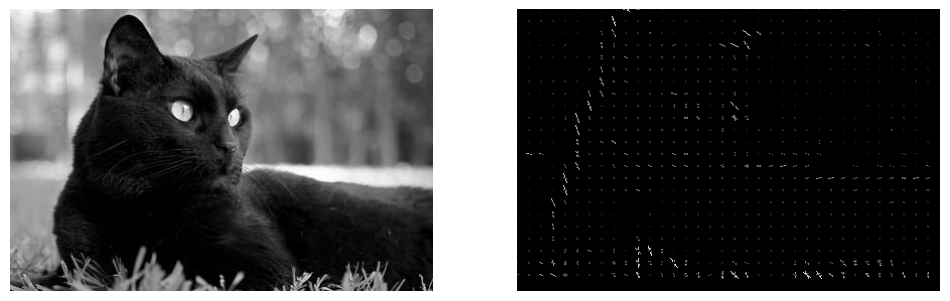

In [ ]:
# Загрузка изображения из Google Drive
img = cv2.imread("/content/drive/MyDrive/hog/cat.jpg", cv2.IMREAD_GRAYSCALE)

# Кастомная функция нахождения HOG изображения
hog = Hog_descriptor(img, cell_size=12, bin_size=9)
vector, image = hog.extract()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(image, cmap=plt.cm.gray)
ax1.axis('off')
ax2.axis('off')